In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
from scipy import signal
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
import geatpy as ea
plt.rcParams.update({'font.size': 15})

In [9]:
with open('data/training_set_ip_temp_10Hz_active_spike_highth.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('data/training_set_op_temp_10Hz_active_spike_highth.p', 'rb') as fo:
        Y_train_ori = pickle.load(fo, encoding='bytes')
with open('data/testing_set_ip_temp_10Hz_active_spike_highth.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('data/testing_set_op_temp_10Hz_active_spike_highth.p', 'rb') as fo:
        Y_test_ori = pickle.load(fo, encoding='bytes')

In [10]:
len(Y_train_ori)

100

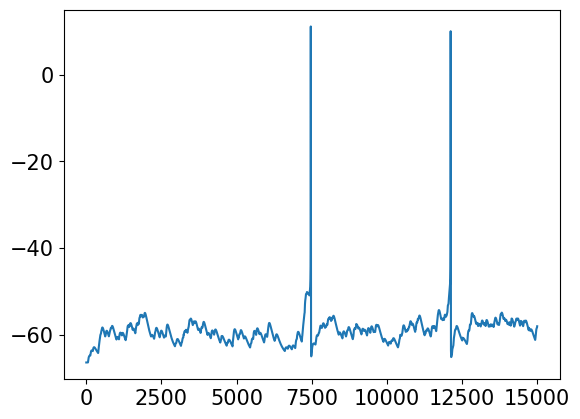

In [4]:
plt.plot(Y_train_ori[13])

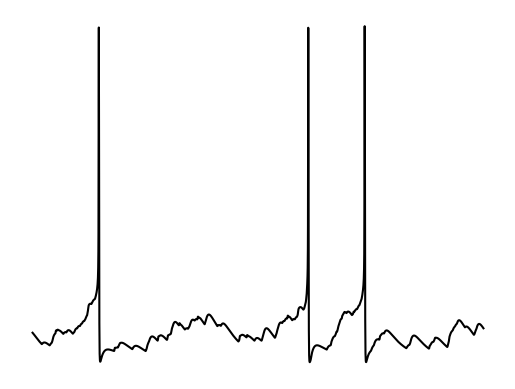

In [5]:
t = np.linspace(0,100, 5001)
ax = plt.subplot(111)
ax.plot(t, Y_train_ori[8][10000:], color='black')
ax.spines[['top','right','left','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('figure/spike_3', bbox_inches='tight')

In [11]:
Y_train = Y_train_ori[:, ::5]
Y_test = Y_test_ori[:, ::5]

Text(0, 0.5, 'V(mV)')

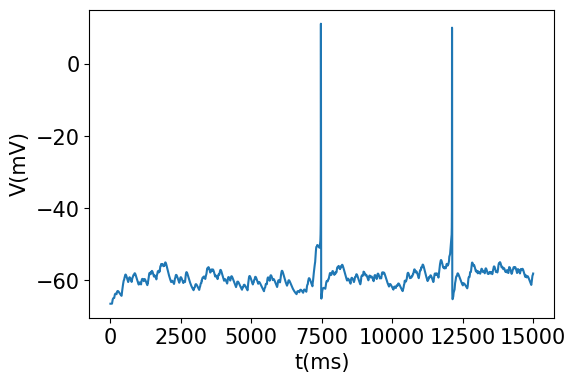

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(Y_train_ori[13])
plt.xlabel('t(ms)')
plt.ylabel('V(mV)')
# plt.savefig('figure/reset_trace_example', bbox_inches='tight')

In [13]:
# change the input from the list to array
Nsyn = 9
stimulus_duration_ms = Y_train.shape[1]
def list2array(X):
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, stimulus_duration_ms))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*Nsyn+j]:
                if spike_time <= 3000:
                    X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_array = list2array(X_train)
X_test_array = list2array(X_test)

In [14]:
def create_single_PSP_kernel(tau_rise, tau_decay, temporal_filter_length):

    exp_r = signal.exponential(M=temporal_filter_length, center=0, tau=tau_rise , sym=False)
    exp_d = signal.exponential(M=temporal_filter_length, center=0, tau=tau_decay, sym=False)

    post_syn_potential = exp_d - exp_r
    post_syn_potential /= post_syn_potential.max()

    return post_syn_potential

def construct_normlized_synaptic_filter(tau_rise_vec, tau_decay_vec, time_dur):

    num_synapses = tau_rise_vec.shape[0]
    # temporal_filter_length = int(4 * tau_decay_vec.max()) + 1
    temporal_filter_length = time_dur

    syn_filter = np.zeros((num_synapses, temporal_filter_length))

    for k, (tau_r, tau_d) in enumerate(zip(tau_rise_vec, tau_decay_vec)):
        syn_filter[k,:] = create_single_PSP_kernel(tau_r, tau_d, temporal_filter_length=time_dur)

    return syn_filter

def simulate_bilinear_network(presynaptic_input_spikes, synaptic_weights, tau_rise_vec, tau_decay_vec, kappa, time_dur,
                                           refreactory_time_constant=50, v_reset=-75, v_threshold=-55):
    num_synapses = tau_rise_vec.shape[0]
    # temporal_filter_length = int(5 * refreactory_time_constant) + 1
    temporal_filter_length = time_dur

    refreactory_filter = signal.exponential(M=temporal_filter_length,center=0,tau=refreactory_time_constant,sym=False)[np.newaxis,:]

    # padd input and get all synaptic filters
    normlized_syn_filter = np.flipud(construct_normlized_synaptic_filter(tau_rise_vec, tau_decay_vec, time_dur))

    # calc local PSP
    local_PSP = np.zeros(presynaptic_input_spikes.shape)
    for k in range(num_synapses):
        local_PSP[k] = synaptic_weights[k] * signal.convolve(presynaptic_input_spikes[k], normlized_syn_filter[k])[:time_dur]

    linear_term = np.sum(local_PSP, axis=0)

    # create a tensor with N*N*T, the first two axis are the element product of the local PSP
    T = np.repeat(local_PSP[np.newaxis, :, :], num_synapses, axis=0) * np.repeat(local_PSP[:, np.newaxis, :], num_synapses, axis=1)
    # kappa = np.random.rand(num_synapses**2)
    # kappa = np.array([2, 0, 2, 2])
    U = np.triu(kappa.reshape(num_synapses,num_synapses), k=1)
    bilinear_term = np.sum(T * U[:, :, np.newaxis], axis=(0, 1))

    # simulate the cell
    soma_voltage = v_reset + linear_term + bilinear_term
    output_spike_times_in_ms = []

    # reset mechanism
    for t in range(len(soma_voltage)):
        if (soma_voltage[t] > v_threshold) and ((t + 1) < len(soma_voltage)):
            t_start = t + 1
            t_end = min(len(soma_voltage), t_start + temporal_filter_length)
            soma_voltage[t_start:t_end] -= (soma_voltage[t + 1] - v_reset) * refreactory_filter.ravel()[:(t_end - t_start)]
            # t_end = min(len(soma_voltage)-5, t_start + temporal_filter_length)
            # soma_voltage[t_start+5:t_end+5] -= (soma_voltage[t_start+5] - v_reset) * refreactory_filter.ravel()[:(t_end - t_start)]
            output_spike_times_in_ms.append(t)

    return local_PSP, soma_voltage, output_spike_times_in_ms

In [15]:
Y_train_copy = Y_train.copy()
Y_train_copy[13][np.where(Y_train_copy[13]>-50)] = -50

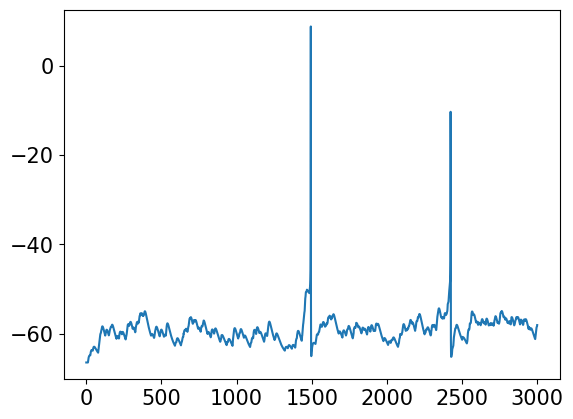

In [16]:
plt.plot(Y_train[13])

In [19]:
X_train_array.shape

(100, 9, 3001)

In [17]:
# parameters
num_synapses = 9
refreactory_time_constant= 70
v_reset= -66
v_threshold=-0

# tau_rise_vec  = np.array([4.97073304, 5.16980324, 5.26765269, 3.82514844, 5.63027838,
#         5.08219279, 5.63254899, 5.22369909, 5.42967368])
# tau_decay_vec = np.array([49.8179765 , 50.01758009, 50.03512872, 49.91236068, 50.01350019,
#         49.7776923 , 50.11498149, 49.92856838, 50.12770377])
# kappa = np.ones(81) * -0.03
# synaptic_weights_vec = np.array([0.83827295, 0.85052868, 0.80179661, 0.7294805 , 0.74807033,
#         0.80211093, 0.79185269, 0.79898527, 0.87370513]) * 2
tau_rise_vec = np.ones(9) * 5
tau_decay_vec = np.ones(9) * 50
kappa = np.ones(81) * -0.05
synaptic_weights_vec = np.ones(9) * 1.6


Vars = np.hstack((synaptic_weights_vec, tau_rise_vec, tau_decay_vec, kappa))

local_normlized_currents, soma_voltage, output_spike_times_in_ms = simulate_bilinear_network(X_train_array,
                                                                                                          synaptic_weights_vec, tau_rise_vec, tau_decay_vec, kappa,
                                                                                                          time_dur=stimulus_duration_ms,
                                                                                                          refreactory_time_constant=refreactory_time_constant,
                                                                                                          v_reset=v_reset, v_threshold=v_threshold,
                                                                                                          )

ValueError: volume and kernel should have the same dimensionality

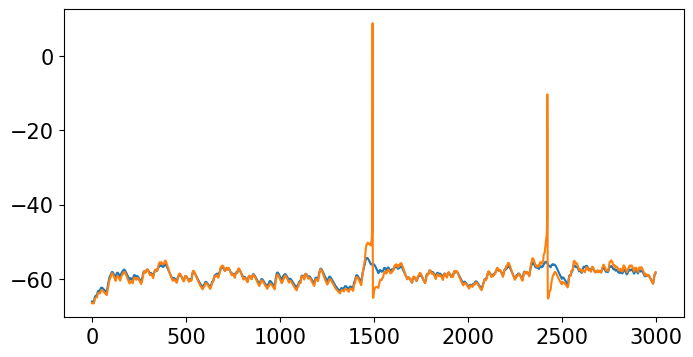

In [154]:
plt.figure(figsize=(8, 4))
plt.plot(soma_voltage)
plt.plot(Y_train[13])

In [26]:
def evalVars(Vars):
    local_normlized_currents, soma_voltage, output_spike_times_in_ms = simulate_bilinear_network(X_train_array[13],
                                                                                                          Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:],
                                                                                                          time_dur=stimulus_duration_ms,
                                                                                                          refreactory_time_constant=refreactory_time_constant,
                                                                                                          v_reset=v_reset, v_threshold=v_threshold,
                                                                                                          )
    f = np.mean(np.square(soma_voltage - Y_train[13]))
    return f

In [21]:
evalVars(Vars)

4.221438905862941

In [145]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 10})
with open('pars/pars_reset_y_train13.p', 'wb') as f:
    pickle.dump(res.x, f)

         Current function value: 3.567798
         Iterations: 10
         Function evaluations: 1526
         Gradient evaluations: 14


In [71]:
with open('/home/mjy/project/bilinear_network/pars/pars_reset_y_train13.p', 'rb') as fo:
    Vars2 = pickle.load(fo, encoding='bytes')

In [72]:
# Vars2 = res.x
v_reset = -66
v_threshold = -54.7
local_normlized_currents, soma_voltage, output_spike_times_in_ms = simulate_bilinear_network(X_train_array[13],
                                                                                                          Vars2[0:9], Vars2[9:18], Vars2[18:27], Vars2[27:],
                                                                                                          time_dur=stimulus_duration_ms,
                                                                                                          refreactory_time_constant=refreactory_time_constant,
                                                                                                          v_reset=v_reset, v_threshold=v_threshold,
                                                                                                          )

In [144]:
Vars3 = Vars2.copy()
Vars3[2] += 0.2
Vars3[5] -= 0.2
Vars3[1] += 0.2
Vars3[4] -= 0.2

In [145]:
local_normlized_currents, soma_voltage2, output_spike_times_in_ms = simulate_bilinear_network(X_train_array[13],
                                                                                                          Vars3[0:9], Vars3[9:18], Vars3[18:27], Vars3[27:],
                                                                                                          time_dur=stimulus_duration_ms,
                                                                                                          refreactory_time_constant=refreactory_time_constant,
                                                                                                          v_reset=v_reset, v_threshold=v_threshold,
                                                                                                          )

In [73]:
np.sum((soma_voltage[:1400]-Y_train[13][:1400])**2) / np.sum((np.mean(Y_train[13][:1400])-Y_train[13][:1400])**2)

0.0464033069247515

In [45]:
evalVars(Vars2)

6.115970579869224

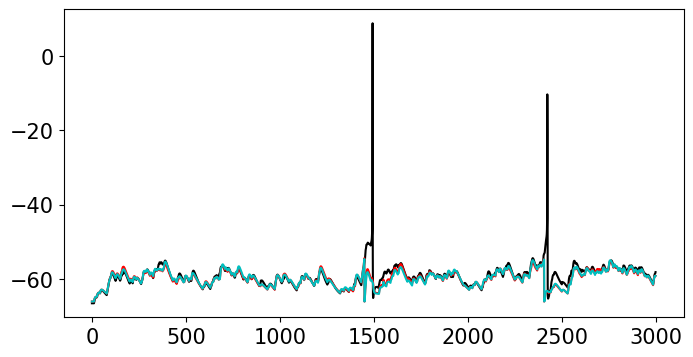

In [146]:
plt.figure(figsize=(8, 4))
plt.plot(Y_train[13],color='black', label='real')
plt.plot(soma_voltage2,color='r', label='predict')
plt.plot(soma_voltage,color='c', label='predict')

In [101]:
a = soma_voltage
b = Y_train[13]
a = np.delete(a, np.s_[1450:1494])
b = np.delete(b, np.s_[1450:1494])
a[1451]= b[1451]

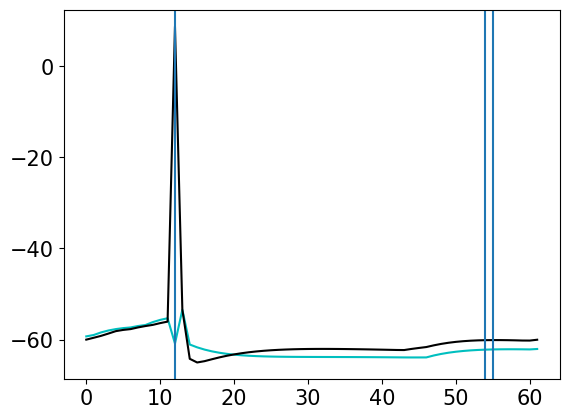

In [102]:
plt.plot(a[1438:1500],color='c', label='predict')
plt.plot(b[1438:1500],color='black', label='predict')
plt.axvline(x=12)
plt.axvline(x=54)
plt.axvline(x=55)

In [75]:
x = np.zeros(99)
for i in range(99):
    x[i] = np.exp(-i/refreactory_time_constant)

In [131]:
a = np.delete(soma_voltage, np.s_[1490:1523])
c = np.delete(soma_voltage2, np.s_[1490:1523])
b = np.delete(Y_train[13], np.s_[1457:1490])
a = np.delete(a, np.s_[1460:1467])
c = np.delete(c, np.s_[1460:1467])
b = np.delete(b, np.s_[1440:1447])
a[1440:1450] = b[1440:1450]
c[1440:1450] = b[1440:1450]
a = np.delete(a, np.s_[2390:2405])
c = np.delete(c, np.s_[2390:2405])
b = np.delete(b, np.s_[2320:2335])
a[2340:2363] = b[2340:2363]
c[2340:2363] = b[2340:2363]
a = np.delete(a, np.s_[2365:2371])
c = np.delete(c, np.s_[2365:2371])
b = np.delete(b, np.s_[2380:2386])
a = np.delete(a, np.s_[1451:1454])
c = np.delete(c, np.s_[1451:1454])
b = np.delete(b, np.s_[1460:1463])
a = np.delete(a, np.s_[2360:2362])
c = np.delete(c, np.s_[2360:2362])
b = np.delete(b, np.s_[2380:2382])
a[2400:2499] += 3*x
c[2400:2499] += 3*x

In [77]:
c = np.delete(Y_train_ori[13], np.s_[1465*5:1490*5])

In [78]:
len(a)

2935

In [79]:
t1 = np.linspace(0,6000, len(a))
t2 = np.linspace(0, 6000, len(c))

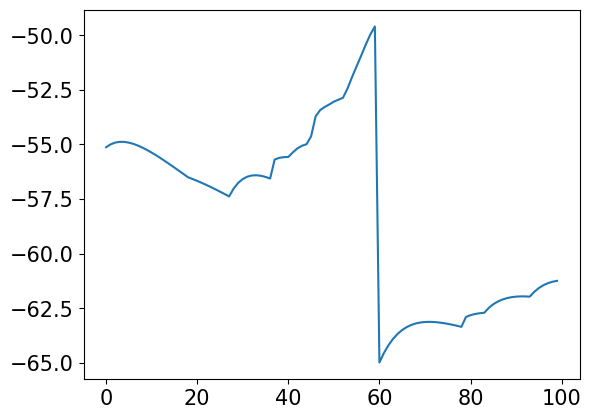

In [80]:
plt.plot(a[2300:2400])

In [107]:
b[1454]=b[2366]=0
t=np.linspace(0,6,len(a))

In [150]:
a = np.delete(soma_voltage, np.s_[1490:1523])
c = np.delete(soma_voltage2, np.s_[1490:1523])
b = np.delete(Y_train[13], np.s_[1457:1490])
a = np.delete(a, np.s_[1460:1467])
c = np.delete(c, np.s_[1460:1467])
b = np.delete(b, np.s_[1440:1447])
a[1440:1450] = b[1440:1450]
c[1440:1450] = b[1440:1450]
a = np.delete(a, np.s_[2390:2405])
c = np.delete(c, np.s_[2390:2405])
b = np.delete(b, np.s_[2320:2335])
a[2340:2363] = b[2340:2363]
c[2340:2363] = b[2340:2363]
a = np.delete(a, np.s_[2365:2371])
c = np.delete(c, np.s_[2365:2371])
b = np.delete(b, np.s_[2380:2386])
a = np.delete(a, np.s_[1451:1454])
c = np.delete(c, np.s_[1451:1454])
b = np.delete(b, np.s_[1460:1463])
a = np.delete(a, np.s_[2360:2362])
c = np.delete(c, np.s_[2360:2362])
b = np.delete(b, np.s_[2380:2382])
a[2400:2499] += 3*x
c[2400:2499] += 3*x
a[1456:1551] = a[1456:1551] + (b[1456:1551] - a[1456:1551]) * 0.6
c[1456:1551] = c[1456:1551] + (b[1456:1551] - c[1456:1551]) * 0.6

In [153]:
b[1454]=b[2366]=0
t=np.linspace(0,6,len(a))

In [151]:
len(c)

2935

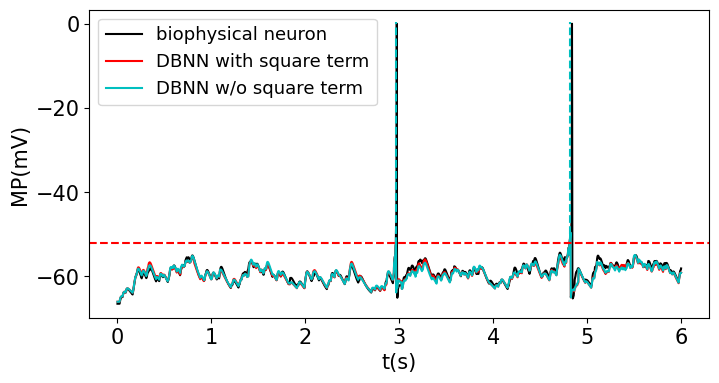

In [169]:
plt.figure(figsize=(8, 4))
plt.plot(t,b,color='black', label='biophysical neuron')
plt.plot(t,c,color='r', label='DBNN with square term')
plt.plot(t,a,color='c', label='DBNN w/o square term')
plt.axvline(2.97, ymin=0.2, ymax=0.96, c='c', ls='--')
plt.axvline(4.820, ymin=0.2, ymax=0.96, c='c', ls='--')
plt.axhline(-52, c='r', ls='--')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.0), fontsize=13)
plt.xlabel('t(s)')
plt.ylabel('MP(mV)')
plt.savefig('figure/reset_trace_with_square', bbox_inches='tight',dpi=800)

In [167]:
a[350:400] = a[350:400] + (b[350:400] - a[350:400]) * 0.6
c[350:400] = c[350:400] + (b[350:400] - c[350:400]) * 0.6

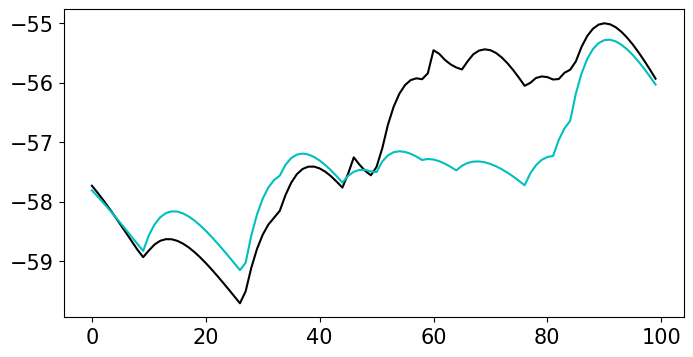

In [166]:
plt.figure(figsize=(8, 4))
plt.plot(b[300:400],color='black', label='real')
plt.plot(a[300:400],color='c', label='predict')

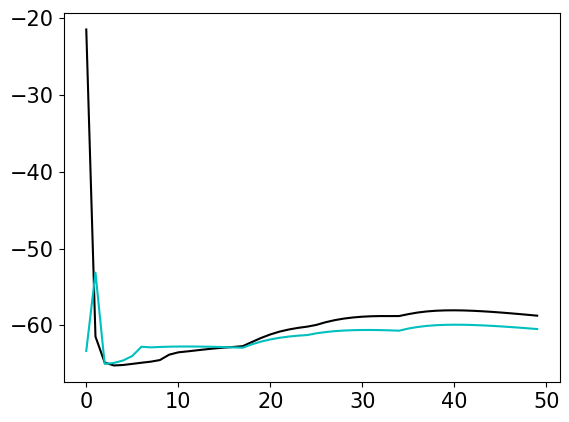

In [261]:
plt.plot(b[2400:2450],color='black', label='real')
plt.plot(a[2400:2450],color='c', label='real')

Text(0, 0.5, 'V(mV)')

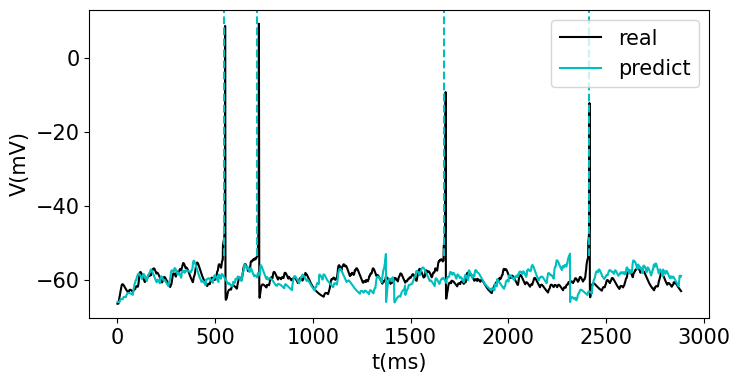

In [59]:
plt.figure(figsize=(8, 4))
a = np.delete(soma_voltage, np.s_[570:615])
b = np.delete(Y_train[6], np.s_[540:585])

a = np.delete(a, np.s_[765:800])
b = np.delete(b, np.s_[720:755])

a = np.delete(a, np.s_[1685:1700])
b = np.delete(b, np.s_[1670:1685])

a = np.delete(a, np.s_[2430:2450])
b = np.delete(b, np.s_[2410:2430])


plt.plot(b, color='black', label='real')
plt.plot(a, color='c', label='predict')

plt.axvline(543, ymin=0.2, ymax=1, c='c', ls='--')
plt.axvline(715, ymin=0.2, ymax=1, c='c', ls='--')
plt.axvline(1670, ymin=0.2, ymax=1, c='c', ls='--')
plt.axvline(2415, ymin=0.2, ymax=1, c='c', ls='--')

plt.legend()
plt.xlabel('t(ms)')
plt.ylabel('V(mV)')
# plt.savefig('figure/reset_trace_2')

In [276]:
b[b > v_threshold] = v_threshold

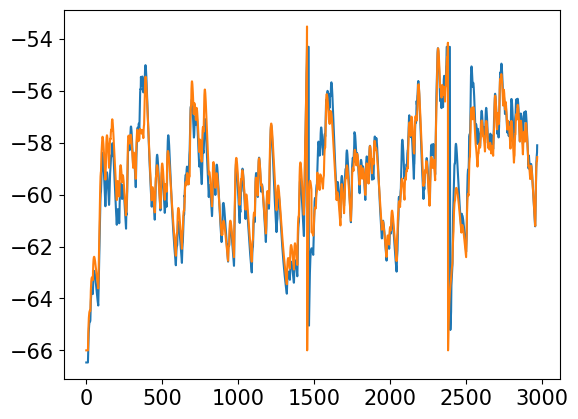

In [279]:
plt.plot(b)
plt.plot(a)

In [283]:
a = [1,2,3,4]
b = [1,2,3,4]

In [350]:
ve = 1 - (np.sum((a[800:1500]-b[800:1500])**2)) / (np.sum((b[800:1500]-np.mean(b[800:1500]))**2))
ve

0.8410155314355279

In [2]:
print('ve = ', ve)


NameError: name 've' is not defined

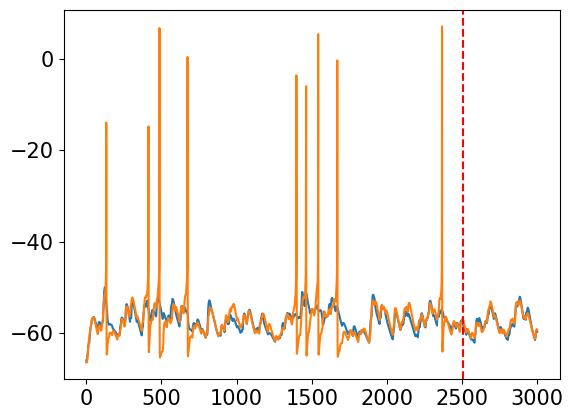

In [398]:
plt.plot(soma_voltage)
plt.plot(Y_train[0])
plt.axvline(x=2505, c='r', ls='--')

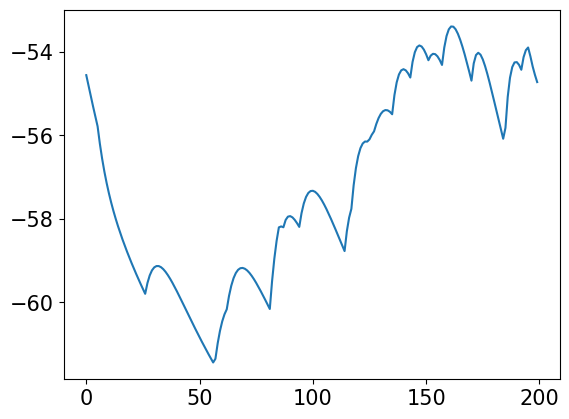

In [307]:
plt.plot(soma_voltage[600:800])